# Taxi Compass
by Alejandro Seif

# **Day 1: Data Collection**

## LTA Taxi Availability data API

* Import statement

In [1]:
import requests
import pandas as pd
import time
from datetime import datetime
import numpy as np

### Sequential Taxi Data API Interaction

This Information updates every 50-60 seconds, so this service can be called at most 1x per minute

In [3]:
gov = 'https://api.data.gov.sg/v1'
taxi_url = '/transport/taxi-availability'

url = gov + taxi_url
response = requests.get(url).json()

response

{'type': 'FeatureCollection',
 'crs': {'type': 'link',
  'properties': {'href': 'http://spatialreference.org/ref/epsg/4326/ogcwkt/',
   'type': 'ogcwkt'}},
 'features': [{'type': 'Feature',
   'geometry': {'type': 'MultiPoint',
    'coordinates': [[103.6208, 1.27543],
     [103.629028816667, 1.29692938333333],
     [103.63047, 1.30362],
     [103.64044, 1.32894],
     [103.64229, 1.3313],
     [103.64394, 1.32579],
     [103.64865, 1.32125],
     [103.64888, 1.33658],
     [103.65387, 1.32779],
     [103.65936, 1.32],
     [103.66102, 1.31064],
     [103.66284, 1.31551],
     [103.66703, 1.29552],
     [103.67245, 1.27815],
     [103.68104, 1.33],
     [103.685260883333, 1.34188793333333],
     [103.68657, 1.34],
     [103.68709, 1.34],
     [103.68712, 1.34325],
     [103.688713166667, 1.34112716666667],
     [103.688912833333, 1.34283283333333],
     [103.68945, 1.34515],
     [103.69029, 1.33968],
     [103.69039, 1.3424],
     [103.690400183333, 1.34169023333333],
     [103.69138, 

In [4]:
timestamp_str = response['features'][0]['properties']['timestamp']
timestamp = datetime.strptime(timestamp_str, '%Y-%m-%dT%H:%M:%S+08:00')
print(timestamp)

2021-12-21 20:29:39


In [5]:
taxi_coordinates = response['features'][0]['geometry']['coordinates']
taxi_coordinates_df= pd.DataFrame.from_dict(taxi_coordinates)
taxi_coordinates_df= taxi_coordinates_df.rename(columns = {0:'lon',1:'lat'})
taxi_coordinates_df['timestamp']=timestamp
taxi_coordinates_df.astype({'lat':'float32','lon':'float32'})
taxi_coordinates_df

,lon,lat,timestamp
0,103.620800,1.275430,2021-12-21 20:29:39
1,103.629029,1.296929,2021-12-21 20:29:39
2,103.630470,1.303620,2021-12-21 20:29:39
3,103.640440,1.328940,2021-12-21 20:29:39
4,103.642290,1.331300,2021-12-21 20:29:39
...,...,...,...
2892,103.990760,1.360780,2021-12-21 20:29:39
2893,103.990820,1.359610,2021-12-21 20:29:39
2894,103.998017,1.389153,2021-12-21 20:29:39
2895,104.001980,1.374470,2021-12-21 20:29:39


Now we are going to be setting up a function to retrieve and append so that it can be called

In [6]:
def taxi_coordinates_append(df):
    '''
    Pass an existing dataframe to append more data
    '''
    gov = 'https://api.data.gov.sg/v1'
    taxi_url = '/transport/taxi-availability'

    url = gov + taxi_url
    response = requests.get(url).json()
    
    timestamp_str = response['features'][0]['properties']['timestamp']
    timestamp = datetime.strptime(timestamp_str, '%Y-%m-%dT%H:%M:%S+08:00')
    
    taxi_coordinates = response['features'][0]['geometry']['coordinates']
    temp_taxi_coordinates_df= pd.DataFrame.from_dict(taxi_coordinates)
    temp_taxi_coordinates_df= temp_taxi_coordinates_df.rename(columns = {0:'lon',1:'lat'})
    temp_taxi_coordinates_df['timestamp']=timestamp
    temp_taxi_coordinates_df.astype({'lat':'float32','lon':'float32'})
    return pd.concat([df,temp_taxi_coordinates_df])
    

In [7]:
taxi_coordinates_append(taxi_coordinates_df)

,lon,lat,timestamp
0,103.620800,1.275430,2021-12-21 20:29:39
1,103.629029,1.296929,2021-12-21 20:29:39
2,103.630470,1.303620,2021-12-21 20:29:39
3,103.640440,1.328940,2021-12-21 20:29:39
4,103.642290,1.331300,2021-12-21 20:29:39
...,...,...,...
2892,103.990760,1.360780,2021-12-21 20:29:39
2893,103.990820,1.359610,2021-12-21 20:29:39
2894,103.998017,1.389153,2021-12-21 20:29:39
2895,104.001980,1.374470,2021-12-21 20:29:39


### Weather data API Interaction

This service updates once every 5 minutes

In [8]:
gov = 'https://api.data.gov.sg/v1'
weather_api = '/environment/rainfall'

url = gov+weather_api
response = requests.get(url).json()

response

{'metadata': {'stations': [{'id': 'S77',
    'device_id': 'S77',
    'name': 'Alexandra Road',
    'location': {'latitude': 1.2937, 'longitude': 103.8125}},
   {'id': 'S109',
    'device_id': 'S109',
    'name': 'Ang Mo Kio Avenue 5',
    'location': {'latitude': 1.3764, 'longitude': 103.8492}},
   {'id': 'S90',
    'device_id': 'S90',
    'name': 'Bukit Timah Road',
    'location': {'latitude': 1.3191, 'longitude': 103.8191}},
   {'id': 'S114',
    'device_id': 'S114',
    'name': 'Choa Chu Kang Avenue 4',
    'location': {'latitude': 1.38, 'longitude': 103.73}},
   {'id': 'S50',
    'device_id': 'S50',
    'name': 'Clementi Road',
    'location': {'latitude': 1.3337, 'longitude': 103.7768}},
   {'id': 'S107',
    'device_id': 'S107',
    'name': 'East Coast Parkway',
    'location': {'latitude': 1.3135, 'longitude': 103.9625}},
   {'id': 'S215',
    'device_id': 'S215',
    'name': 'GEYLANG EAST CENTRAL',
    'location': {'latitude': 1.32785, 'longitude': 103.88899}},
   {'id': 'S118

In [9]:
response['items'][0]['timestamp']

'2021-12-21T20:20:00+08:00'

In [10]:
response['metadata']['stations'][0]

{'id': 'S77',
 'device_id': 'S77',
 'name': 'Alexandra Road',
 'location': {'latitude': 1.2937, 'longitude': 103.8125}}

In [11]:
response['items'][0]['readings'][0]

{'station_id': 'S77', 'value': 0}

In [12]:
{'id':response['metadata']['stations'][0]['id'], 
 'lat':response['metadata']['stations'][0]['location']['latitude'],
'lon':response['metadata']['stations'][0]['location']['longitude'],
'value':response['items'][0]['readings'][0]['value'],
'timestamp':response['items'][0]['timestamp']}

{'id': 'S77',
 'lat': 1.2937,
 'lon': 103.8125,
 'value': 0,
 'timestamp': '2021-12-21T20:20:00+08:00'}

In [13]:
weather_list = []
for index,value in enumerate(response['items'][0]['readings']):
    weather_list.append({'id':response['metadata']['stations'][index]['id'], 
 'lat':response['metadata']['stations'][index]['location']['latitude'],
'lon':response['metadata']['stations'][index]['location']['longitude'],
'value':response['items'][0]['readings'][index]['value'],
'timestamp':response['items'][0]['timestamp']})

In [14]:
pd.DataFrame(weather_list)

,id,lat,lon,value,timestamp
0,S77,1.29370,103.81250,0,2021-12-21T20:20:00+08:00
1,S109,1.37640,103.84920,0,2021-12-21T20:20:00+08:00
2,S90,1.31910,103.81910,0,2021-12-21T20:20:00+08:00
3,S114,1.38000,103.73000,0,2021-12-21T20:20:00+08:00
4,S50,1.33370,103.77680,0,2021-12-21T20:20:00+08:00
...,...,...,...,...,...
62,S69,1.37000,103.80500,0,2021-12-21T20:20:00+08:00
63,S08,1.37010,103.82710,0,2021-12-21T20:20:00+08:00
64,S116,1.28100,103.75400,0,2021-12-21T20:20:00+08:00
65,S104,1.44387,103.78538,0,2021-12-21T20:20:00+08:00


In [15]:
def parse_rainfall_data():
    '''
    This function calls the rainfall API
    and parses it into a dataframe.
    Available columns are id, lat, lon, value and timestamp
    
    value represents rainfall, where 0 is no rain.
    '''
    gov = 'https://api.data.gov.sg/v1'
    weather_api = '/environment/rainfall'

    url = gov+weather_api
    response = requests.get(url).json()

    timestamp_str = response['items'][0]['timestamp']
    timestamp = datetime.strptime(timestamp_str, '%Y-%m-%dT%H:%M:%S+08:00')
    weather_list = []
    for index,value in enumerate(response['items'][0]['readings']):
        weather_list.append({'id':response['metadata']['stations'][index]['id'], 
     'lat':response['metadata']['stations'][index]['location']['latitude'],
    'lon':response['metadata']['stations'][index]['location']['longitude'],
    'value':response['items'][0]['readings'][index]['value'],
    'timestamp': timestamp})
        
    return pd.DataFrame(weather_list)

parse_rainfall_data()

,id,lat,lon,value,timestamp
0,S77,1.29370,103.81250,0,2021-12-21 20:20:00
1,S109,1.37640,103.84920,0,2021-12-21 20:20:00
2,S90,1.31910,103.81910,0,2021-12-21 20:20:00
3,S114,1.38000,103.73000,0,2021-12-21 20:20:00
4,S50,1.33370,103.77680,0,2021-12-21 20:20:00
...,...,...,...,...,...
62,S69,1.37000,103.80500,0,2021-12-21 20:20:00
63,S08,1.37010,103.82710,0,2021-12-21 20:20:00
64,S116,1.28100,103.75400,0,2021-12-21 20:20:00
65,S104,1.44387,103.78538,0,2021-12-21 20:20:00


## Ranked distance between lat lon points - pandas apply

Given 2 sets of (lat,lon) this function is to calculate the 
haversine distance between a point and a set of fixed points 
then find the nearby pairs, ranked by distance

In [16]:
from math import radians, sin, cos, asin, sqrt

def haversine_distance(lon1, lat1, lon2, lat2):
    """
    Compute distance between two pairs of coordinates (lon1, lat1, lon2, lat2)
    See - (https://en.wikipedia.org/wiki/Haversine_formula)
    Distance is measured in kilometers when r = 6371
    r = 6371  Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    Lats and Longs are converted to radians first then computed used haversine
    """
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    radius = 6371
    return 2 * radius * asin(sqrt(a))

df = parse_rainfall_data()
df

,id,lat,lon,value,timestamp
0,S77,1.29370,103.81250,0,2021-12-21 20:20:00
1,S109,1.37640,103.84920,0,2021-12-21 20:20:00
2,S90,1.31910,103.81910,0,2021-12-21 20:20:00
3,S114,1.38000,103.73000,0,2021-12-21 20:20:00
4,S50,1.33370,103.77680,0,2021-12-21 20:20:00
...,...,...,...,...,...
62,S69,1.37000,103.80500,0,2021-12-21 20:20:00
63,S08,1.37010,103.82710,0,2021-12-21 20:20:00
64,S116,1.28100,103.75400,0,2021-12-21 20:20:00
65,S104,1.44387,103.78538,0,2021-12-21 20:20:00


In [17]:
test_lat, test_lon = 1.41720, 103.74855

df['distance']=df.apply(lambda row: haversine_distance(row.lon, row.lat, test_lon, test_lat)
                        , axis=1)
df.sort_values(by='distance')

,id,lat,lon,value,timestamp,distance
66,S100,1.41720,103.74855,0,2021-12-21 20:20:00,0.000000
34,S211,1.42918,103.75711,0,2021-12-21 20:20:00,1.637055
12,S66,1.43870,103.73630,0,2021-12-21 20:20:00,2.751303
33,S210,1.44003,103.76904,0,2021-12-21 20:20:00,3.410601
3,S114,1.38000,103.73000,0,2021-12-21 20:20:00,4.621935
...,...,...,...,...,...,...
30,S207,1.32485,103.95836,0,2021-12-21 20:20:00,25.483672
5,S107,1.31350,103.96250,0,2021-12-21 20:20:00,26.431268
61,S24,1.36780,103.98260,0,2021-12-21 20:20:00,26.591031
46,S224,1.34392,103.98409,0,2021-12-21 20:20:00,27.421859


In [110]:
def point_to_set_ranked_distance(test_lat, test_lon, df, cutoff=10):
    '''
    Provide a test latitude and longitude to compare with 
    a dataframe df, which has columns 'lat' and 'lon'
    '''
    df = df[['lat','lon']]
    df['distance']=df.apply(lambda row: haversine_distance(row.lon, row.lat, test_lon, test_lat)
                        , axis=1)
    return df.sort_values(by='distance').iloc[:cutoff]

In [113]:
df = df.drop(columns=['distance'])
point_to_set_ranked_distance(1.3137, 103.99, df)

,lat,lon,distance
31,1.31360,104.00317,1.464095
5,1.31350,103.96250,3.057138
46,1.34392,103.98409,3.423933
30,1.32485,103.95836,3.729395
35,1.31835,103.93574,6.053966
54,1.34370,103.94440,6.068271
61,1.36780,103.98260,6.071630
21,1.36620,103.95280,7.154020
16,1.30648,103.91040,8.885147
22,1.30703,103.89067,11.066984


So far this is OK-fast for comparing 1 point with a set of fixed points (e.g. a taxi with all taxi-stands).
Doing this for all taxis (and all taxi stands) might be time consuming (1-2 minutes?)

## Day 3


### Taxi Stop Data

This data is avaiable as a GeoJSON in:
https://data.gov.sg/dataset/lta-taxi-stop?resource_id=113b362f-ffc7-4e06-adb1-1c06e8b8ae90



In [20]:
import json

with open('../raw_data/lta-taxi-stop-geojson.geojson') as geofile:
    taxi_stands_json = json.load(geofile)

taxi_stands_json

{'type': 'FeatureCollection',
 'crs': {'type': 'name',
  'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
 'features': [{'type': 'Feature',
   'properties': {'Name': 'kml_1',
    'Description': '<center><table><tr><th colspan=\'2\' align=\'center\'><em>Attributes</em></th></tr><tr bgcolor="#E3E3F3"> <th>TYPE_CD</th> <td>TSTAND</td> </tr><tr bgcolor=""> <th>TYPE_CD_DE</th> <td>TAXI STAND</td> </tr><tr bgcolor="#E3E3F3"> <th>INC_CRC</th> <td>58C6A265B6301AC8</td> </tr><tr bgcolor=""> <th>FMEL_UPD_D</th> <td>20200722155614</td> </tr></table></center>'},
   'geometry': {'type': 'Point',
    'coordinates': [103.844358266128, 1.28126053659933, 0.0]}},
  {'type': 'Feature',
   'properties': {'Name': 'kml_2',
    'Description': '<center><table><tr><th colspan=\'2\' align=\'center\'><em>Attributes</em></th></tr><tr bgcolor="#E3E3F3"> <th>TYPE_CD</th> <td>TSTAND</td> </tr><tr bgcolor=""> <th>TYPE_CD_DE</th> <td>TAXI STAND</td> </tr><tr bgcolor="#E3E3F3"> <th>INC_CRC</th> <td>F771A37F645

I will now parse the contents so as to keep the Name and Coordinates of taxi stands

In [22]:
taxi_stands_dict = []

for ts in taxi_stands_json['features']:
    taxi_stands_dict.append( {'ts_id':ts['properties']['Name'],'lat':ts['geometry']['coordinates'][1] ,
                                                'lon':ts['geometry']['coordinates'][0]})
ts_df = pd.DataFrame(taxi_stands_dict)
ts_df.head()

,ts_id,lat,lon
0,kml_1,1.281261,103.844358
1,kml_2,1.281409,103.847446
2,kml_3,1.310559,103.847510
3,kml_4,1.282391,103.845270
4,kml_5,1.282479,103.846251


### Ranked distance between lat lon points - numpy broadcasting

Given 2 sets of (lat,lon) this function is to calculate the 
haversine distance between a point and a set of fixed points 
then find the nearby pairs, ranked by distance

In [65]:
def find_nearest_taxi_stand(taxi_lat=1.281261,taxi_lon=103.846358):
    '''
    Given all the static positions of the nearby taxi stands
    we can get the distance with all of them, and return the nearest 10 taxi stands.
    
    We can assume that a taxi is IN the taxi stand when the distance is < 100 m = 0.1 km
    
    Python wise we'll be using broadcasting method, so we do the difference of all taxi stands (ts)
    with a given taxi_lat and taxi_lon in one shot, not in a for loop.
    '''

    taxi_lat_rad = np.deg2rad(taxi_lat)
    taxi_lon_rad = np.deg2rad(taxi_lon)

    ts_lat = np.array(ts_df['lat'].tolist())
    ts_lat_rad = np.deg2rad(ts_lat)

    ts_lon = np.array(ts_df['lon'].tolist())
    ts_lon_rad = np.deg2rad(ts_lon)

    dlat = ts_lat_rad - taxi_lat_rad
    dlon = ts_lon_rad - taxi_lon_rad

    d = np.sin(dlat/2)**2 + np.cos(ts_lat_rad)*np.cos(taxi_lat_rad) * np.sin(dlon/2)**2
    distance =  2 * 6371 * np.arcsin(np.sqrt(d))

    df = ts_df.copy()
    df['distance']=distance
    df.sort_values(by='distance', inplace=True)
    return df.iloc[:10]

taxi_lat = 1.2732
taxi_long = 103.9435

find_nearest_taxi_stand(taxi_lat, taxi_lon)

,ts_id,lat,lon,distance
203,kml_204,1.273704,103.844904,0.171066
201,kml_202,1.274667,103.847052,0.180481
202,kml_203,1.275701,103.846129,0.279302
206,kml_207,1.273448,103.843802,0.285530
205,kml_206,1.275052,103.843317,0.395832
204,kml_205,1.274180,103.842683,0.422783
247,kml_248,1.275872,103.843248,0.455838
188,kml_189,1.277374,103.847483,0.480658
189,kml_190,1.277435,103.848901,0.549259
194,kml_195,1.278369,103.845087,0.591854


### Count taxis in taxi_stands

Here we'll use the available taxi information to find all the taxis that are already near (<100m) taxistands.
I will have a counter for each timestamp, so that we can return a timestamped dataframe with the taxi count for each taxi stand. I expect most to be zero.


In [151]:
taxi_url = "https://api.data.gov.sg/v1/transport/taxi-availability"
r = requests.get(taxi_url)
coordinates = r.json()["features"][0]["geometry"]["coordinates"]
timestamp_str = r.json()['features'][0]['properties']['timestamp']
timestamp = datetime.strptime(timestamp_str, '%Y-%m-%dT%H:%M:%S+08:00')

KeyError: 'features'

In [ ]:
ts_counter = dict(zip(ts_df['ts_id'].tolist(),[0 for _ in ts_df['ts_id'].tolist()]))

for taxi_coordinates in coordinates:
    lon,lat = taxi_coordinates
    d_df = find_nearest_taxi_stand(lat,lon)
    d_df = d_df[d_df['distance']<0.1]
    for ts in d_df['ts_id'].tolist():
        ts_counter[ts] += 1

In [117]:
tmp_taxi_stand_counter = pd.DataFrame.from_dict(ts_counter, orient='index')
tmp_taxi_stand_counter.reset_index(inplace=True)
tmp_taxi_stand_counter['timestamp'] = timestamp
tmp_taxi_stand_counter = tmp_taxi_stand_counter.rename(columns={0:'taxi_count', 'index':'ts_id'})
# tmp_taxi_stand_counter
ts_df.merge(tmp_taxi_stand_counter)

,ts_id,lat,lon,taxi_count,timestamp
0,kml_1,1.281261,103.844358,0,2021-12-21 21:55:43
1,kml_2,1.281409,103.847446,0,2021-12-21 21:55:43
2,kml_3,1.310559,103.847510,0,2021-12-21 21:55:43
3,kml_4,1.282391,103.845270,0,2021-12-21 21:55:43
4,kml_5,1.282479,103.846251,0,2021-12-21 21:55:43
...,...,...,...,...,...
345,kml_346,1.305252,103.851618,0,2021-12-21 21:55:43
346,kml_347,1.312201,103.837586,1,2021-12-21 21:55:43
347,kml_348,1.276219,103.820254,0,2021-12-21 21:55:43
348,kml_349,1.341340,103.961546,1,2021-12-21 21:55:43


In [115]:
r.json()['features'][0]['properties']['timestamp']

'2021-12-21T21:28:41+08:00'

In [118]:
def get_taxi_stands():
    taxi_stands_dict = []
    for ts in taxi_stands_json['features']:
        taxi_stands_dict.append( {'ts_id':ts['properties']['Name'],'lat':ts['geometry']['coordinates'][1] ,
                                                    'lon':ts['geometry']['coordinates'][0]})
    ts_df = pd.DataFrame(taxi_stands_dict)
    return ts_df

def count_taxis_in_ts():
    taxi_url = "https://api.data.gov.sg/v1/transport/taxi-availability"
    r = requests.get(taxi_url)
    coordinates = r.json()["features"][0]["geometry"]["coordinates"]
    timestamp_str = r.json()['features'][0]['properties']['timestamp']
    timestamp = datetime.strptime(timestamp_str, '%Y-%m-%dT%H:%M:%S+08:00')
    
    ts_counter = dict(zip(ts_df['ts_id'].tolist(),[0 for _ in ts_df['ts_id'].tolist()]))

    for taxi_coordinates in coordinates:
        lon,lat = taxi_coordinates
        d_df = find_nearest_taxi_stand(lat,lon)
        d_df = d_df[d_df['distance']<0.1]
        for ts in d_df['ts_id'].tolist():
            ts_counter[ts] += 1
    
    tmp_taxi_stand_counter = pd.DataFrame.from_dict(ts_counter, orient='index')
    tmp_taxi_stand_counter.reset_index(inplace=True)
    tmp_taxi_stand_counter['timestamp'] = timestamp
    tmp_taxi_stand_counter = tmp_taxi_stand_counter.rename(columns={0:'taxi_count', 'index':'ts_id'})
    # tmp_taxi_stand_counter
    return ts_df.merge(tmp_taxi_stand_counter)

ts_df = get_taxi_stands()
ts_taxi_df = count_taxis_in_ts()
ts_taxi_df

,ts_id,lat,lon,taxi_count,timestamp
0,kml_1,1.281261,103.844358,2,2021-12-23 10:36:37
1,kml_2,1.281409,103.847446,1,2021-12-23 10:36:37
2,kml_3,1.310559,103.847510,17,2021-12-23 10:36:37
3,kml_4,1.282391,103.845270,4,2021-12-23 10:36:37
4,kml_5,1.282479,103.846251,4,2021-12-23 10:36:37
...,...,...,...,...,...
345,kml_346,1.305252,103.851618,1,2021-12-23 10:36:37
346,kml_347,1.312201,103.837586,1,2021-12-23 10:36:37
347,kml_348,1.276219,103.820254,3,2021-12-23 10:36:37
348,kml_349,1.341340,103.961546,0,2021-12-23 10:36:37


## Testing gcloud storage for cloud functions


In [141]:
from google.cloud import storage
BUCKET_NAME = 'static-file-storage'
BUCKET_TAXI_STAND_GEOJSON_PATH = 'lta-taxi-stop-geojson.geojson'
public_path = 'https://storage.cloud.google.com/static-file-storage/lta-taxi-stop-geojson.geojson'
# Add Client() here
client = storage.Client()
path = f"gs://{BUCKET_NAME}/{BUCKET_TAXI_STAND_GEOJSON_PATH}"
local_path = '/Users/alejandroseif/Downloads/lta-taxi-stop-geojson.geojson'
# geojson_gcloud_path = 'gs://static-file-storage/lta-taxi-stop-geojson.geojson'
with open(local_path) as geofile:
    '''
    Take geojson file provided by LTA where the taxi stands coordinates are provided
    '''
    taxi_stands_json = json.load(geofile)
taxi_stands_json

{'type': 'FeatureCollection',
 'crs': {'type': 'name',
  'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
 'features': [{'type': 'Feature',
   'properties': {'Name': 'kml_1',
    'Description': '<center><table><tr><th colspan=\'2\' align=\'center\'><em>Attributes</em></th></tr><tr bgcolor="#E3E3F3"> <th>TYPE_CD</th> <td>TSTAND</td> </tr><tr bgcolor=""> <th>TYPE_CD_DE</th> <td>TAXI STAND</td> </tr><tr bgcolor="#E3E3F3"> <th>INC_CRC</th> <td>58C6A265B6301AC8</td> </tr><tr bgcolor=""> <th>FMEL_UPD_D</th> <td>20200722155614</td> </tr></table></center>'},
   'geometry': {'type': 'Point',
    'coordinates': [103.844358266128, 1.28126053659933, 0.0]}},
  {'type': 'Feature',
   'properties': {'Name': 'kml_2',
    'Description': '<center><table><tr><th colspan=\'2\' align=\'center\'><em>Attributes</em></th></tr><tr bgcolor="#E3E3F3"> <th>TYPE_CD</th> <td>TSTAND</td> </tr><tr bgcolor=""> <th>TYPE_CD_DE</th> <td>TAXI STAND</td> </tr><tr bgcolor="#E3E3F3"> <th>INC_CRC</th> <td>F771A37F645

In [ ]:
### GCP Storage - - - - - - - - - - - - - - - - - - - - - -
BUCKET_NAME = 'static-file-storage'
BUCKET_TAXI_STAND_GEOJSON_PATH = 'lta-taxi-stop-geojson.geojson'
public_path = 'https://storage.cloud.google.com/static-file-storage/lta-taxi-stop-geojson.geojson'
# Add Client() here
client = storage.Client()
path = f"gs://{BUCKET_NAME}/{BUCKET_TAXI_STAND_GEOJSON_PATH}"

In [143]:
from google.cloud import storage


"""Downloads a blob from the bucket."""
# The ID of your GCS bucket
bucket_name = 'static-file-storage'

# The ID of your GCS object
source_blob_name = 'lta-taxi-stop-geojson.geojson'

# The path to which the file should be downloaded
# destination_file_name = "local/path/to/file"

storage_client = storage.Client()

bucket = storage_client.bucket(bucket_name)

# Construct a client side representation of a blob.
# Note `Bucket.blob` differs from `Bucket.get_blob` as it doesn't retrieve
# any content from Google Cloud Storage. As we don't need additional data,
# using `Bucket.blob` is preferred here.
blob = bucket.blob(source_blob_name)
#     blob.download_to_filename(destination_file_name)
# blob.open()
# blob.path
geofile = blob.open()
taxi_stands_json = json.load(geofile)
taxi_stands_json

Forbidden: 403 GET https://storage.googleapis.com/download/storage/v1/b/static-file-storage/o/lta-taxi-stop-geojson.geojson?alt=media: wagon-service-account@wagon-bootcamp-706.iam.gserviceaccount.com does not have storage.objects.get access to the Google Cloud Storage object.: ('Request failed with status code', 403, 'Expected one of', <HTTPStatus.OK: 200>, <HTTPStatus.PARTIAL_CONTENT: 206>)

## Changing API to get Taxis in real time to LTA data mall

In [213]:
taxi_url = "https://api.data.gov.sg/v1/transport/taxi-availability"
r = requests.get(taxi_url)
r.json()
# coordinates = r.json()["features"][0]["geometry"]["coordinates"]

{'api_info': {'status': 'healthy'}, 'message': 'no results found'}

In [208]:
def get_taxi_coordinates_from_lta():
    taxi_coordinates =[]
    for index in range(20):
        skip=0+500*index
    #     print(f'skip at {skip}')
        uri = f'http://datamall2.mytransport.sg/ltaodataservice/Taxi-Availability?$skip={skip}'
        headers = { 'AccountKey' : 'BehS/IpVR0KOFQ+BgFqM5g==',
        'accept' : 'application/json'} #this is by default
        r = requests.get(url=uri, headers=headers).json()
        if len(requests.get(url=uri, headers=headers).json()["value"]) == 0:
            break
        taxi_coordinates += r['value']
    return taxi_coordinates
# print('Done')

In [217]:
temp = get_taxi_coordinates_from_lta()

In [235]:
for taxi_coordinates in coordinates:
        lon = taxi_coordinates['Longitude']
        lat = taxi_coordinates['Latitude']
        print(lon,lat)
        

103.76456 1.3073
103.85863 1.32401
103.91861 1.30745
103.90818 1.33142
103.88892 1.38225
103.8871 1.32214
103.83364 1.30379
103.94782 1.3719
103.85478 1.29973
103.85957 1.32656
103.84642 1.27536
103.9684 1.34498
103.89351 1.3964
103.78283 1.4362
103.86297 1.30207
103.94574 1.37542
103.78557 1.43423
103.85801 1.33186
103.84394 1.28478
103.78407 1.40727
103.86207 1.31231
103.98718 1.35494
103.80167 1.27429
103.84165 1.43704
103.7432 1.38139
103.85242 1.27814
103.84414 1.28595
103.92683 1.32961
103.83886 1.28134
103.88168 1.37039
103.85087 1.30501
103.84675 1.34542
103.88118 1.35645
103.90761 1.30806
103.84964 1.30183
103.87566 1.29279
103.82584 1.25414
103.8531 1.31811
103.85677 1.36758
103.84917 1.37022
103.78655 1.34439
103.82761 1.28712
103.89757 1.39199
103.86165 1.2889
103.85044 1.32473
103.90093 1.32671
103.74596 1.40098
103.88655 1.36137
103.78977 1.43839
103.76053 1.35426
103.8045 1.44438
103.87246 1.39152
103.88645 1.36129
103.83783 1.28571
103.88083 1.3186
103.85975 1.28959
103

103.76867 1.38804
103.85637 1.29627
103.92911 1.32408
103.84116 1.42969
103.85262 1.33359
103.81169 1.44319
103.7047 1.34692
103.86001 1.32525
103.83015 1.36519
103.81615 1.29498
103.66798 1.29861
103.7854 1.43561
103.95819 1.3463
103.84089 1.30296
103.94995 1.37317
103.83603 1.44342
103.84758 1.29037
103.78352 1.33577
103.89477 1.36557
103.89501 1.37607
103.84468 1.41747
103.83344 1.28562
103.90296 1.38507
103.84827 1.27833
103.91796 1.33753
103.85569 1.3003
103.87386 1.36048
103.86234 1.31708
103.9095 1.33163
103.80574 1.33965
103.83176 1.35493
103.90154 1.35619
103.74467 1.33389
103.86043 1.30459
103.72609 1.35193
103.94973 1.37308
103.92425 1.38753
103.83518 1.27901
103.83115 1.3124
103.7839 1.29518
103.84698 1.3362
103.84293 1.29953
103.74282 1.34118
103.7929 1.43469
103.95924 1.35673
103.84703 1.27568
103.82581 1.3006
103.85661 1.2899
103.85699 1.36894
103.83939 1.24551
103.91456 1.33728
103.91009 1.32578
103.86879 1.32913
103.76519 1.36994
103.79871 1.27785
103.82785 1.38798
103

103.79885 1.44587
103.94843 1.33713
103.78728 1.4123
103.88444 1.3022
103.89126 1.37833
103.74771 1.38356
103.7726 1.40618
103.81867 1.30688
103.84931 1.36975
103.90124 1.3984
103.85287 1.29948
103.84815 1.42062
103.8962 1.33806
103.83024 1.31704
103.85509 1.29991
103.86936 1.31989
103.87125 1.39193
103.79727 1.31281
103.83265 1.29387
103.85721 1.35542
103.8896 1.30029
103.89462 1.40006
103.83791 1.30344
103.76787 1.29267
103.82605 1.29024
103.82048 1.44946
103.8326 1.41577
103.95734 1.36839
103.74822 1.38369
103.854 1.28049
103.82975 1.29535
103.77413 1.37759
103.8582 1.34918
103.69981 1.3571
103.72357 1.35231
103.86022 1.28192
103.85 1.27936
103.87455 1.32386
103.69644 1.33149
103.82724 1.30696
103.74347 1.33247
103.8565 1.29667
103.87646 1.37504
103.85553 1.27657
103.85647 1.35563
103.70119 1.34745
103.92487 1.36814
103.84244 1.42114
103.79646 1.44747
103.91386 1.33974
103.76037 1.33915
103.87208 1.3915
103.83024 1.27697
103.85413 1.31917
103.74367 1.40141
103.71314 1.27812
103.7034

103.81357 1.45
103.81877 1.28
103.89651 1.4
103.88661 1.34
103.93929 1.36
103.7776 1.44
103.81144 1.29
103.84574 1.37
103.93198 1.37
103.82806 1.29
103.70088 1.34
103.8618 1.35
103.85715 1.4
103.7923 1.45
103.84956 1.34
103.89562 1.37
103.8694 1.34
103.83686 1.37
103.9125 1.39
103.85418 1.29
103.85564 1.36
103.8037 1.45
103.66316 1.32
103.85581 1.39
103.94715 1.36
103.76406 1.38
103.85618 1.31
103.85493 1.4
103.75617 1.38
103.83628 1.44
103.86415 1.3
103.85391 1.36
103.78391 1.31
103.79889 1.44
103.82657 1.28
103.83496 1.44
103.79482 1.45
103.87702 1.35
103.83624 1.42
103.86004 1.34
103.88594 1.39
103.83358 1.43
103.77536 1.32
103.82731 1.43
103.86957 1.32
103.95578 1.34
103.79691 1.44
103.766 1.36
103.8858 1.37
103.77024 1.39
103.8534 1.31
103.94799 1.35
103.82744 1.43
103.72658 1.35
103.85338 1.3
103.85387 1.3
103.82046 1.45
103.90552 1.33
103.77157 1.44
103.90176 1.31
103.80515 1.45
103.77256 1.43
103.83415 1.42
103.80105 1.43
103.87318 1.37
103.85826 1.3
103.88875 1.32
103.87625 1.

103.870667666667 1.37270066666667
103.844387333333 1.31046116666667
103.902148833333 1.35655783333333
103.905173166667 1.33091666666667
103.705815833333 1.3445505
103.861003833333 1.372272
103.940080166667 1.35126816666667
103.9456025 1.3764065
103.854708833333 1.335722
103.833692333333 1.28990816666667
103.917831833333 1.30742766666667
103.857723333333 1.29787583333333
103.8443105 1.31048333333333
103.864476333333 1.32607633333333
103.836631833333 1.421496
103.949491166667 1.31190166666667
103.917464666667 1.38222633333333
103.889750166667 1.31520383333333
103.845894333333 1.29939166666667
103.789482 1.430262
103.709010666667 1.34036416666667
103.873810833333 1.309357
103.7454425 1.33954483333333
103.9854105 1.35213216666667
103.8490045 1.36531483333333
103.818921333333 1.4504585
103.903306166667 1.38249183333333
103.765542 1.35840783333333
103.937615833333 1.346051
103.891706666667 1.37942666666667
103.859971833333 1.3080795
103.747563166667 1.3970305
103.901677 1.38331483333333
103.

In [211]:
print(datetime.now())

2021-12-28 08:46:51.050356


### Issues with deg2grad type in GCP

In [216]:
np.deg2rad(1.3)#, dtype='float64')

0.022689280275926284

# Query from BigQuery

## Example using BigQuery on an open dataset

In [2]:
%load_ext google.cloud.bigquery


In [14]:
# !pip install --upgrade 'google-cloud-bigquery[bqstorage,pandas]'


In [3]:
%%bigquery test1
SELECT
    source_year AS year,
    COUNT(is_male) AS birth_count
FROM `bigquery-public-data.samples.natality`
GROUP BY year
ORDER BY year DESC
LIMIT 15

Downloading: 100%|████████████████████████████| 15/15 [00:02<00:00,  6.53rows/s]


In [21]:
test1

,year,birth_count
0,2008,4255156
1,2007,4324008
2,2006,4273225
3,2005,4145619
4,2004,4118907
5,2003,4096092
6,2002,4027376
7,2001,4031531
8,2000,4063823
9,1999,3963465


## Credentials needed to access BigQuery in our project :: Querying taxi stands by taxi count


In [17]:
import os
from google.cloud import bigquery
bq_key_path = '/Users/alejandroseif/Documents/GCP/BigQuerykey/taxi-compass-lewagon-0548ea55c10c.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = bq_key_path
bigquery_client = bigquery.Client(project='taxi-compass-lewagon')

In [13]:
ts_id = '"kml_59"'
ts_id_list = ("kml_1","kml_2","kml_59")
QUERY = f"""
SELECT *
FROM `taxi-compass-lewagon.api_dataset.h_taxi_stand_taxi_count`
WHERE taxi_count > 0
ORDER BY timestamp DESC
LIMIT 5000
"""

QUERY_TS =f"""
SELECT timestamp, taxi_count
FROM `taxi-compass-lewagon.api_dataset.h_taxi_stand_taxi_count`
WHERE ts_id = {ts_id}
ORDER BY timestamp DESC
LIMIT 5000
"""

QUERY_TS_LIST =f"""
SELECT timestamp, ts_id, taxi_count
FROM `taxi-compass-lewagon.api_dataset.h_taxi_stand_taxi_count`
WHERE ts_id in {ts_id_list}
ORDER BY timestamp DESC
LIMIT {len(ts_id_list)}
"""

# SELECT timestamp, taxi_count
# WHERE ts_id = {ts_id}

In [18]:
# query_job = bigquery_client.query(QUERY)
query_job = bigquery_client.query(QUERY_TS_LIST)

query_df = query_job.to_dataframe()
query_df

,timestamp,ts_id,taxi_count
0,2022-01-12 15:25:06.397697+00:00,kml_1,0
1,2022-01-12 15:25:06.397697+00:00,kml_2,0
2,2022-01-12 15:25:06.397697+00:00,kml_59,1


<AxesSubplot:xlabel='timestamp'>

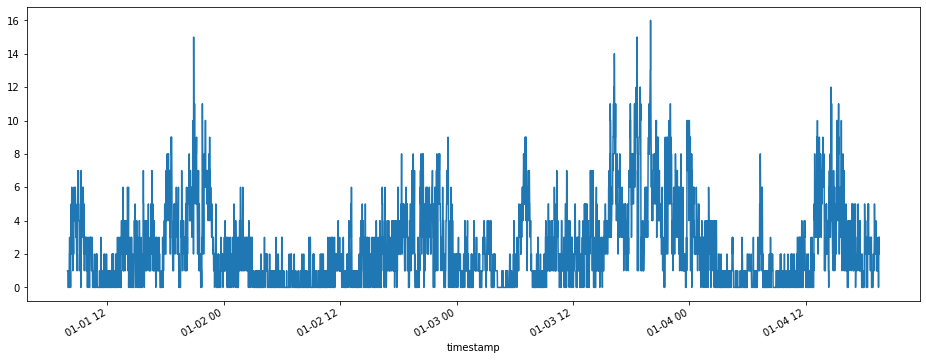

In [20]:
query_df.set_index(query_df['timestamp'])['taxi_count'].plot(figsize=(16,6))

In [23]:
QUERY_INPUT_DATA='''SELECT  a.mrt_stn, a.taxi_st_id, b.*, c.*
FROM `taxi-compass-lewagon.api_dataset.c_mrt_stn_taxi_stand` as a
inner join `taxi-compass-lewagon.api_dataset.h_mrt_status_availability` as b
on a.mrt_stn = b.stn_id
inner join `taxi-compass-lewagon.api_dataset.h_taxi_stand_taxi_count` as c 
on a.taxi_st_id = c.ts_id'''

query_job = bigquery_client.query(QUERY_INPUT_DATA)

query_df = query_job.to_dataframe()
query_df

KeyboardInterrupt: 

In [5]:
hours = 48
QUERY_FULL = f"""
select x.taxi_st_id,  substr(x.taxi_st_id,5) taxi_st_num,  x.taxi_count, x.taxi_update_time, x.weather_stn_id, c.rainfall, c.weather_update_time, x.mrt_stn_id, e.mrt_final_status, e.mrt_update_time
    from (
    select a.taxi_st_id, a.taxi_count, a.taxi_update_time, b.weather_stn_id, d.mrt_stn_id
    from (
    SELECT ts_id as taxi_st_id, taxi_count, cast(timestamp_trunc(timestamp, minute) as datetime) as taxi_update_time
    FROM `taxi-compass-lewagon.api_dataset.h_taxi_stand_taxi_count`
    WHERE timestamp > TIMESTAMP_SUB(CURRENT_TIMESTAMP() , INTERVAL {hours} hour)
    ) a
left join
    (
    select weather_stn_id, taxi_st_id from `taxi-compass-lewagon.api_dataset.c_taxi_stand_weather_stn`
    ) b on a.taxi_st_id = b.taxi_st_id
left join 
    (
    select taxi_st_id, mrt_stn as mrt_stn_id from `taxi-compass-lewagon.api_dataset.c_mrt_stn_taxi_stand`
    where mrt_stn is not null
    ) d on a.taxi_st_id = d.taxi_st_id
    )x
left join 
    (
    select station_id as weather_stn_id, rainfall, datetime_trunc(datetime (update_time), minute) as weather_update_time
    from `taxi-compass-lewagon.api_dataset.h_weather_rainfall`
    where datetime(update_time) > datetime_SUB(CURRENT_DATETIME() , INTERVAL {hours} hour)
    ) c on x.weather_stn_id = c.weather_stn_id and x.taxi_update_time = c.weather_update_time
left join
    (
    select stn_id as mrt_stn_id, final_status as mrt_final_status, datetime_trunc(datetime (update_time), minute) as mrt_update_time 
    from `taxi-compass-lewagon.api_dataset.h_mrt_status_availability`
    where datetime(update_time) > datetime_SUB(CURRENT_DATETIME() , INTERVAL {hours} hour)
    ) e on x.taxi_update_time = e.mrt_update_time and x.mrt_stn_id = e.mrt_stn_id
"""
#WHERE x.taxi_st_id = 'kml_12'
#"""


query_job = bigquery_client.query(QUERY_FULL)

query_df = query_job.to_dataframe()
query_df

,taxi_st_id,taxi_st_num,taxi_count,taxi_update_time,weather_stn_id,rainfall,weather_update_time,mrt_stn_id,mrt_final_status,mrt_update_time
0,kml_12,12,0,2022-01-11 13:56:00,S211,NaN,NaT,None,NaN,NaT
1,kml_13,13,0,2022-01-11 13:56:00,S226,NaN,NaT,None,NaN,NaT
2,kml_21,21,0,2022-01-11 13:56:00,S90,NaN,NaT,CC19,1.0,2022-01-11 13:56:00
3,kml_21,21,0,2022-01-11 13:56:00,S90,NaN,NaT,DT9,1.0,2022-01-11 13:56:00
4,kml_29,29,0,2022-01-11 13:56:00,S118,NaN,NaT,None,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...
1302968,kml_271,271,14,2022-01-10 20:46:00,S118,NaN,NaT,None,NaN,NaT
1302969,kml_271,271,14,2022-01-10 20:47:00,S118,NaN,NaT,None,NaN,NaT
1302970,kml_271,271,14,2022-01-10 20:43:00,S118,NaN,NaT,None,NaN,NaT
1302971,kml_271,271,14,2022-01-10 21:30:00,S118,0.0,2022-01-10 21:30:00,None,NaN,NaT


In [6]:
df = query_df[["taxi_st_num","taxi_update_time","taxi_count","rainfall","mrt_final_status"]].copy()
df["taxi_st_num"] = df["taxi_st_num"].astype('int64')
df = df.sort_values(by=["taxi_st_num", "taxi_update_time"],ascending=True).reset_index(drop=True)
df[["rainfall"]] = df[["rainfall"]].fillna(df.groupby(['taxi_st_num'])[["rainfall"]].ffill())
df[["mrt_final_status","rainfall"]] = df[["mrt_final_status","rainfall"]].fillna(value=0)

<AxesSubplot:xlabel='taxi_update_time'>

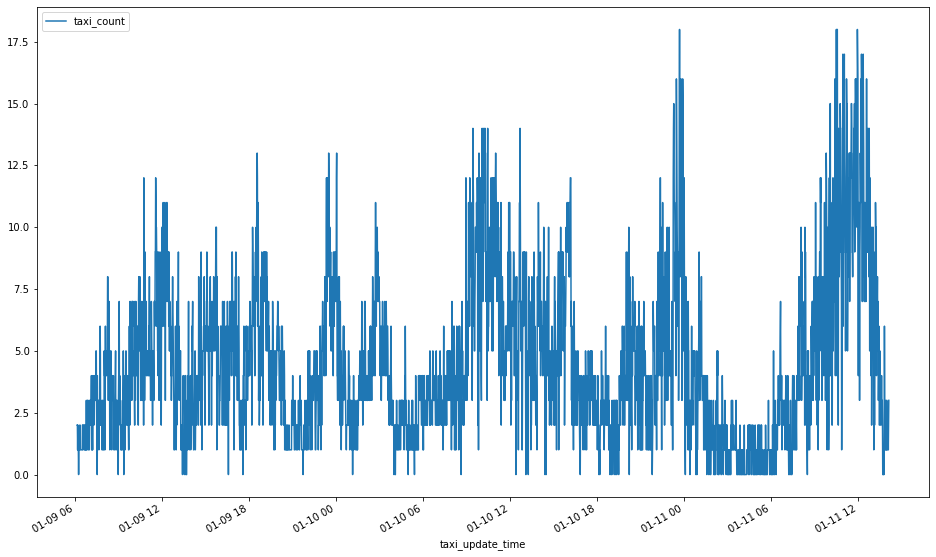

In [7]:
df[df['taxi_st_num']==1][['taxi_update_time','taxi_count']].plot(x='taxi_update_time',y='taxi_count',figsize=(16,10))

# Machine Learning Modeling

In [10]:
X = df[df['taxi_st_num']==1][['taxi_update_time']]
y = df[df['taxi_st_num']==1][['taxi_count']]

In [41]:
X.iloc[0].values[0]

numpy.datetime64('2022-01-09T06:10:00.000000000')

## Basic linear regression
Which makes no sense for this model, because it has periodicity. But just for the hell of it.

In [44]:
from sklearn.linear_model import LinearRegression
import seaborn as sns

model = LinearRegression()
model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [48]:
model.predict(X.iloc[0])

ValueError: Expected 2D array, got 1D array instead:
array=['2022-01-09T06:10:00.000000000'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

## RNN

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential()
model.add(layers.SimpleRNN(units=10, activation = 
                          'tanh'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='mse', optimizer='rmsprop')

2022-01-11 14:29:57.285508: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [51]:

model.fit(X,y,
         batch_size=16,
         epochs=10, verbose=1)

model.predict(X)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported numpy type: NPY_DATETIME).

# API aspects


## Get Lat Long in Python

In [50]:
import geocoder
g = geocoder.ip('me')
print(g.latlng)

     |████████████████████████████████| 98 kB 5.5 MB/s             
[1.3739, 103.7396]


### Use Requests to interact with TS Finder Cloud Function in GCP

In [48]:
import requests

r = requests.post('https://us-central1-taxi-compass-lewagon.cloudfunctions.net/tsfinder', 
                  json={"latitude":1.281260 , "longitude":103.8443})

In [55]:
tuple(r.text.split('-'))

('kml_1',
 'kml_4',
 'kml_6',
 'kml_5',
 'kml_163',
 'kml_254',
 'kml_200',
 'kml_30',
 'kml_195',
 'kml_161')